In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
import torch
import pyvene as pv
import pprint
from task import MetaLearningTask, FineTuningTask
from transformers import BatchEncoding, PretrainedConfig
import jax.random as jr
from torch2jax import j2t, t2j
import dataclasses
import pyreft
import nvidia_smi
from models.mamba import MambaLMHeadModel
from dataclasses import dataclass
from mamba_ssm.utils.generation import InferenceParams
from task import DynamicIntervenableModel, TuneConfig, LoraConfig, ReftConfig
import gc
from models.gpt import GPT, GPTConfig
from models.mamba import MambaLMHeadModel, MambaConfig
from pympler import asizeof
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import lightning as L
from torch.nn import init
from peft import PeftModel, LoraModel
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import jax
from dynamax.hidden_markov_model.parallel_inference import (
    HMMPosteriorFiltered,
    _condition_on,
    FilterMessage,
    lax,
)
import torch.nn as nn

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

In [2]:
nn.Embedding(0, 10)

Embedding(0, 10)

In [2]:
IDS = {
    "mamba": "ale6kz0k",
    "gpt": "duy6u49u",
    "med": "kbun9aq6",
    "small": "gtgytbr8",
    "med1": "yeq4d6zl",
    "small1": "t9iupzpo",
    "explicit": "v7s85nw0",
    "explicit-mlp": "jtnc9w5u"
}

In [3]:
task = MetaLearningTask(IDS['mamba'])
task.to('cuda');

number of parameters: 10.44M
Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [4]:
res = task.evaluate_pp(samples=100, n_steps=300)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
100it [01:25,  1.17it/s]


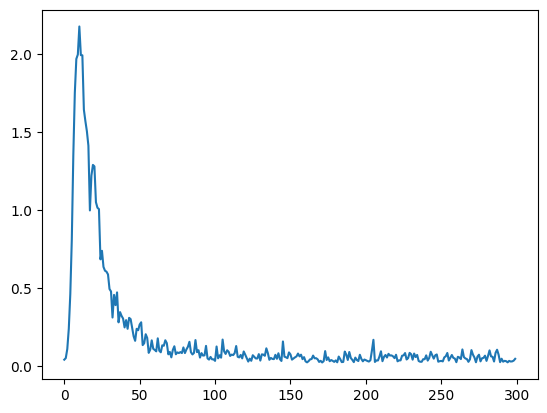

In [21]:
plt.plot(res['BackwardKL'].mean(0))

In [4]:
task.model

MambaLMHeadModel(
  (backbone): MixerModel(
    (embedding): Embedding(56, 384)
    (layers): ModuleList(
      (0-5): 6 x Block(
        (norm): RMSNorm()
        (mixer): Mamba2(
          (in_proj): Linear(in_features=384, out_features=1816, bias=False)
          (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=768, out_features=384, bias=False)
        )
        (norm2): RMSNorm()
        (mlp): GatedMLP(
          (fc1): Linear(in_features=384, out_features=1280, bias=False)
          (fc2): Linear(in_features=640, out_features=384, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=384, out_features=56, bias=False)
)

In [5]:
task.model.config.ssm_cfg = dict(task.model.config.ssm_cfg)
task.model.config = PretrainedConfig.from_dict(dataclasses.asdict(task.model.config))

In [6]:
repr_configs = [
    pv.RepresentationConfig(
        component=f"backbone.layers[{i}].mixer.output",
        intervention=pv.CollectIntervention(embed_dim=384, keep_last_dim=True),
    )
    for i in range(6)
]
intv_model = pv.IntervenableModel(pv.IntervenableConfig(repr_configs), model=task.model)

In [18]:
all_ids = torch.arange(len(task.full_data))
some_ids = torch.randperm(len(task.full_data))[:100]

In [23]:
input_ids = task.full_data.__getitems__(torch.repeat_interleave(some_ids,100), length=300)['input_ids']

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [26]:
latents = []
for batch in tqdm(torch.chunk(input_ids, 100)):
    intv_out = intv_model(
        base=BatchEncoding({"input_ids": batch, "only_last_logits": False}),
        unit_locations={"sources->base": [[[i for i in range(300)]]]},
    )
    latents += [torch.stack(list(intv_out[0][1].values()),-2)[:, [0,9,19,29,39,49,99,199,299]].cpu()]

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [27]:
latents = torch.concatenate(latents,0)

In [32]:
xd = torch.stack(torch.split(latents, 100))

In [ ]:
xd.shape # env, traj, steps, layer, hidden

torch.Size([100, 100, 9, 6, 384])

In [37]:
torch.save(xd, 'latents2.pt')

In [44]:
j2t(task.full_data.index_to_latent[t2j(some_ids)])

tensor([[2, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 0, 2],
        ...,
        [0, 1, 1,  ..., 0, 0, 0],
        [3, 1, 0,  ..., 1, 1, 1],
        [3, 1, 0,  ..., 1, 0, 1]], dtype=torch.int16)

In [45]:
torch.save(j2t(task.full_data.index_to_latent[t2j(some_ids)]), 'envs2.pt')

In [15]:
torch.save(latents, 'hiddens.pt')

In [8]:
latents = torch.stack(list(intv_out[0][1].values()),-2)

In [11]:
latents = latents[:,[0,9,19,29,39,49,99,199,299]]

In [14]:
torch.save(latents, 'latents.pt')

In [17]:
torch.save(j2t(task.full_data.index_to_latent), 'envs1.pt')

In [123]:
torch.save(torch.stack(list(intv_out[0][1].values()), -2), 'lol')

In [131]:
torch.stack(list(intv_out[0][1].values()), -2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.58 GiB. GPU 0 has a total capacity of 44.47 GiB of which 35.19 MiB is free. Including non-PyTorch memory, this process has 44.43 GiB memory in use. Of the allocated memory 37.65 GiB is allocated by PyTorch, and 6.39 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

184

In [ ]:
task.model.forward(base=BatchEncoding({"input_ids": input_ids[:, :i], "only_last_logits": True}
                ),
                unit_locations={"sources->base": (None, [[idx]])},
                return_dict=True,
            )["intervened_outputs"].squeeze(1)[:, : self.model.config.vocab_size]

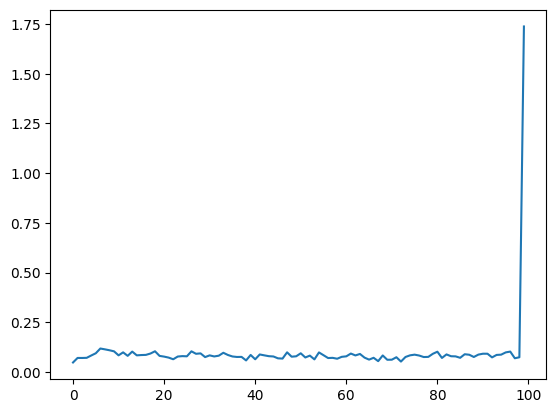

In [17]:
plt.plot(res['BackwardKL'].mean(0))

In [54]:
res['BackwardKL'].mean(0)[0]

tensor(0.2998)

In [30]:
backward_kls = []
for id in ['small', 'small1', 'med', 'med1']:
    task = MetaLearningTask(IDS[id])
    task.to('cuda');
    res = task.evaluate_pp(samples=100, n_steps=100)
    backward_kls.append(res['BackwardKL'].mean(0))

number of parameters: 10.67M
Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


number of parameters: 10.67M
Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


number of parameters: 10.67M
Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


number of parameters: 10.67M
Loaded dataset : (72728/1000)
Loaded checkpoing : last.ckpt


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


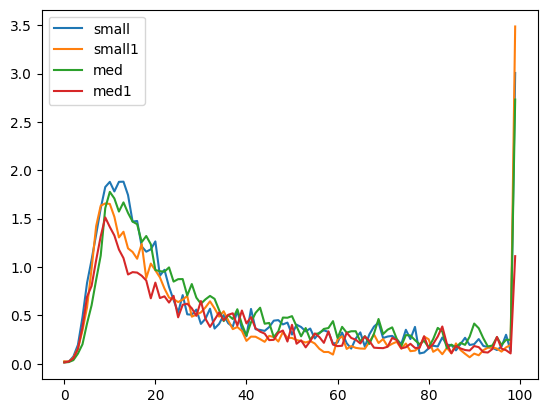

In [31]:
for i, label in enumerate(['small', 'small1', 'med', 'med1']):
    plt.plot(backward_kls[i], label=label)
plt.legend()

In [24]:
res = task.evaluate_pp(samples=100, n_steps=100)

2025-01-09 13:08:00.312091: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 22.81GiB (24495244823 bytes) by rematerialization; only reduced to 29.14GiB (31289369928 bytes), down from 34.58GiB (37128775104 bytes) originally


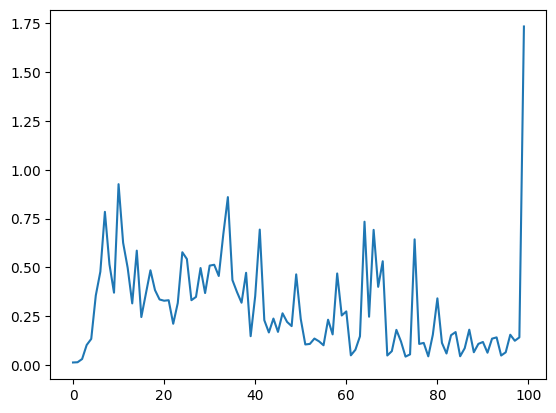

In [25]:
plt.plot(res['BackwardKL'].mean(0))

In [4]:
data = task.full_data

In [40]:
shape = data.get_latents_shape()

In [42]:
embeds = [nn.Embedding(latent_shape, 128) for latent_shape in shape]

In [43]:
embeds[0](j2t(data.index_to_latent[0][0]).long())

tensor([-0.4382, -0.4958, -0.0068, -2.4494, -0.5376,  1.4193,  1.3339, -0.3516,
         1.6402, -0.4905, -1.4399,  1.6723,  1.1414,  0.9649,  0.0243,  0.5217,
         0.4130,  1.3048,  0.3329, -1.3622, -0.7574,  2.0831, -1.0472, -1.8682,
         0.8704, -0.5043,  0.6246, -1.2533, -1.1431,  2.0754,  0.2119, -1.2218,
         0.6570, -0.1799, -0.2295,  0.5835,  0.6064, -0.6995,  0.8708,  0.4396,
        -1.5484, -0.4415, -1.1177, -1.3366,  0.1071,  0.7928, -0.2313,  0.7033,
         1.3434, -0.3522, -0.1502,  0.7534,  0.8807,  0.4620, -1.4660, -0.1272,
         2.1950,  0.1730, -1.2532, -1.7872,  0.8485, -1.2491, -2.2954, -1.2811,
        -0.7002,  1.3637,  0.5726, -1.4288, -0.6267,  0.3882, -0.7235,  0.1043,
         0.3264, -0.0273,  1.5551, -1.3059,  0.2981,  0.6619, -0.3175, -2.5802,
         1.0938,  0.9576, -1.1562, -1.1861,  0.7546,  0.0790, -0.5885, -0.5004,
         0.3835, -2.5881, -0.5601,  1.1336, -0.2857,  1.2520, -1.9062,  0.6635,
        -0.8046,  1.3201, -1.0131, -0.30

In [48]:
xd = torch.stack([embeds[i](j2t(l).long()) for i,l in enumerate(data.index_to_latent[343])])

In [52]:
'xd' in 'asdfdsfdsfd'

False

In [6]:
X,Z = data.sample(6144, 100, jr.PRNGKey(0))

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [50]:
xd.sum(0)

tensor([ 1.9912e+00, -3.1141e+00, -2.6025e+00, -5.1818e+00,  1.5655e-01,
        -1.5245e-01, -6.6721e-01,  3.8440e+00, -2.9507e+00, -2.5420e-01,
        -8.9809e+00,  3.5958e+00,  5.5057e+00, -2.7322e+00,  5.8149e-01,
         1.2137e+01,  4.9215e+00,  3.7918e+00, -1.5763e+00, -2.3740e+00,
         6.9214e-01, -2.9859e+00, -3.0361e+00, -5.3783e+00,  4.9905e+00,
        -2.7419e+00, -1.9106e+00, -7.8844e+00, -1.3665e+00, -1.1602e+00,
        -3.5719e+00,  4.3664e+00,  5.0287e+00, -1.3330e+00,  6.3494e+00,
         8.3571e-01,  1.3834e-01,  2.5662e+00,  1.8630e+00,  1.6457e+00,
        -9.7787e-01, -2.7950e+00, -1.6497e+00,  2.0412e+00,  4.2043e+00,
        -4.1536e-01, -4.4917e-03,  3.6105e+00,  2.3046e-01, -1.0442e+00,
         8.3726e-01, -5.5655e+00,  1.5772e-01, -1.0557e+00, -5.3890e+00,
         2.2242e+00,  3.7358e+00, -1.2096e-01, -1.9987e-01, -4.1118e-01,
         1.5523e+00, -2.1396e+00, -2.5064e+00,  2.5549e+00, -9.3989e-01,
         3.7917e+00, -5.1618e+00, -2.5398e+00,  2.2

In [22]:
oracle = data.bayesian_oracle(jnp.arange(len(data)), X)

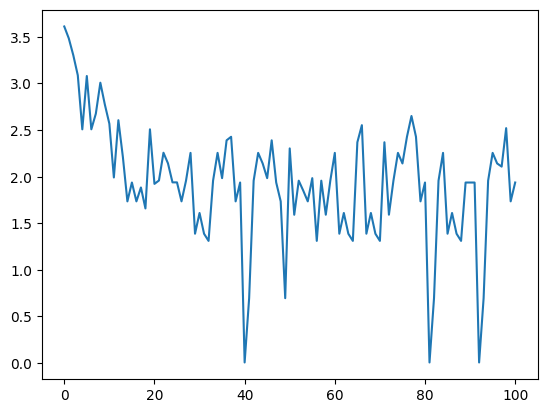

In [19]:
plt.plot(-(jnp.log(oracle['post_pred'])*oracle['post_pred']).sum(-1))

In [20]:
t = jnp.linspace(0,100,1000)

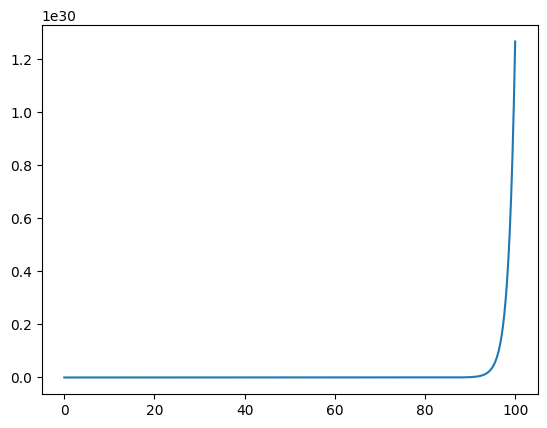

In [21]:
plt.plot(t, 2**t)

In [25]:
task = FineTuningTask(
    TuneConfig(
        IDS["gpt"],
        method_config=LoraConfig(r=4, target_modules="all-linear"),
        context_length=[100,100],
        constraints=[[1, 0]],
        precompute_pp=True,
        prefix_size=[30,60]
    )
).cuda()

number of parameters: 10.67M
Loaded dataset : (11288/1000)


Seed set to 42


Loaded checkpoing : last.ckpt


In [38]:
task.model.disable_adapter()

In [43]:
task.model.__class__.__name__

'PeftModel'

In [31]:
a=a

In [29]:
next(iter(task.val_dataloader()[0]))

{'input_ids': tensor([[12,  1,  1,  ..., 47,  2, 28],
         [ 5, 29,  2,  ..., 16,  0, 42],
         [43, 42, 11,  ...,  2, 15, 12],
         ...,
         [40, 43, 31,  ..., 49,  8, 47],
         [21, 41, 27,  ..., 40, 40, 39],
         [35, 21, 47,  ..., 27, 42,  2]], device='cuda:0', dtype=torch.int32),
 'states': tensor([[ 0,  1, 19,  ..., 14, 10,  3],
         [14,  9, 11,  ...,  2,  1,  5],
         [ 7, 12, 19,  ...,  9,  3,  1],
         ...,
         [ 0,  8, 12,  ...,  7,  6, 15],
         [ 6, 18,  0,  ...,  5, 17, 10],
         [ 7,  6, 18,  ...,  0,  8, 12]], device='cuda:0', dtype=torch.int32),
 'raw_seqs': tensor([[12,  1,  1,  ..., 36,  2, 35],
         [ 5, 29,  2,  ..., 39, 41, 40],
         [43, 42, 11,  ..., 25, 17, 36],
         ...,
         [40, 43, 31,  ..., 43, 47, 21],
         [21, 41, 27,  ..., 29, 36, 10],
         [35, 21, 47,  ..., 33,  2, 15]], device='cuda:0', dtype=torch.int32),
 'raw_states': tensor([[ 0,  1, 19,  ...,  9,  3, 12],
         [14,  9

In [13]:
from torch.utils.data import DataLoader

In [18]:
asdf = DataLoader(
    task.val_data['active'],
    batch_size=32,
    collate_fn=lambda x: x
)

In [16]:
ll, post = jax.vmap(task.full_data.filter, (0,None))(jnp.arange(len(task.full_data)), X)

In [36]:
task_ = FineTuningTask(
    TuneConfig(
        IDS["gpt"],
        method_config=ReftConfig(
            reft_cls="loreft",
            low_rank_dimension=38,
            layers=[1,2,3,4,5],
            t_slice=(-1, None, -1),
            component="output",
        ),
        context_length=[50, 50],
        constraints=[[1, 0], [2, 0], [4, 1], [6, 0], [7, 0]],
        precompute_pp=False,
        prefix_size=(20, 30),
    )
).cuda()

number of parameters: 10.67M
Loaded dataset : (11288/1000)


Seed set to 42


Loaded checkpoing : last.ckpt


In [1]:
task_.trainable_parameters()

NameError: name 'task_' is not defined

In [12]:
trainer = L.Trainer(
    max_steps=100,
    accelerator="gpu",
    enable_checkpointing=False,
    val_check_interval=50,
    reload_dataloaders_every_n_epochs=1,
    check_val_every_n_epoch=None,
)


/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
